In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

from PIL import Image
from IPython import display
import cv2
import moviepy.editor as mpy
from base64 import b64encode

import torch
from torch.nn.functional import grid_sample
from torchvision.transforms.functional import to_tensor, resize

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['image.cmap'] = 'binary'

def tensor_to_img(x):
	return Image.fromarray(x.clip(0, 1).movedim(-3, -1).detach().cpu()
		.multiply(255).type(torch.uint8).numpy())

def file_to_tensor(path):
	return to_tensor(Image.open(path))

def display_video(path, loop=True):
	mp4 = open(path, 'rb').read()
	data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
	display.display(display.HTML(f'''<video src="{
		data_url}" controls=true autoplay=true {
		"loop=true " if loop else ""}/>'''))

In [3]:
video_path = 'datasets/microscope/micro1/micro1.mp4'
frames_path = video_path.rsplit('/', 1)[0] + '/frames'
processed_frames_path = video_path.rsplit('/', 1)[0] + '/processed_frames'
os.makedirs(frames_path, exist_ok=True)
os.makedirs(processed_frames_path, exist_ok=True)

device = 'cuda'

In [21]:
convert_video = False

if convert_video:
	# ~5m
	vidcap = cv2.VideoCapture(video_path)
	frame_id = 0
	# take_range = (100, 121)
	take_range = (0, int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)))
	# n_imgs = take_range[1] - take_range[0]
	n_imgs = 0
	skip_ctr = 0
	for _ in tqdm(range(take_range[1])):
		skip_ctr += 1
		
		success, img = vidcap.read()
		
		if skip_ctr < take_range[0]:
			continue
		if not success:
			print('video ended')
			break
		if skip_ctr >= take_range[1]:
			break
		
		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
		Image.fromarray(img).save(f'{frames_path}/{frame_id}.jpg', quality=95)
		frame_id += 1
		n_imgs += 1
else:
	n_imgs = 9413

100%|█████████▉| 9413/9415 [05:03<00:00, 30.99it/s]


First frame in test range:


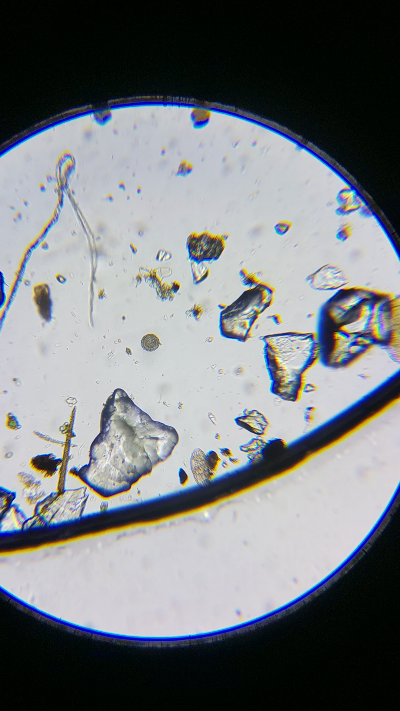

In [22]:
print('First frame in test range:')
img0 = file_to_tensor(f'{frames_path}/0.jpg')
display.display(tensor_to_img(resize(img0, 400)))

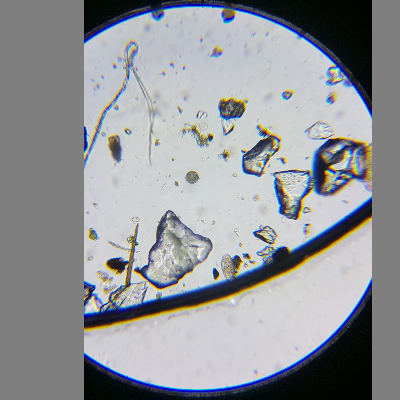

In [23]:
img_shape = (3, 1920, 1080) # (c, h, w)
center = torch.tensor([1010, 435], device=device) # (y, x)
radius = torch.tensor([750], device=device)
# distortion_alphas = torch.nn.Parameter(torch.tensor([-0.01, 0, 0.02], device=device))
distortion_alphas = torch.nn.Parameter(torch.zeros(3, device=device))

def process(img, new_size=400):
	# center cropped img in new_img
	new_img = torch.full((3, radius * 2, radius * 2), .5, device=device)
	img_crop = img[:, max(center[0] - radius, 0) : center[0] + radius,
		max(center[1] - radius, 0) : center[1] + radius]
	offset = (radius - center).maximum(torch.tensor([0], device=device))
	new_img[:, offset[0] : offset[0] + img_crop.shape[1],
		offset[1] : offset[1] + img_crop.shape[2]] = img_crop
	
	# get grid
	grid_x, grid_y = torch.meshgrid(
		*[torch.linspace(-1, 1, radius.item() * 2, device=device)
		for _ in range(2)], indexing='xy'
	)
	grid = torch.stack([grid_x, grid_y], dim=-1)[None]
	# batch dim is used for channel-specific sampling
	grid = grid.repeat(3, 1, 1, 1)
	
	# convert to polar and correct distortion
	polar_r = grid.norm(dim=-1)
	grid_polar = torch.stack([
		polar_r / (1 - distortion_alphas[:, None, None] * polar_r**2),
		torch.atan2(grid[..., 1], grid[..., 0])
	], dim=-1)
	
	# convert back to cartesian
	grid = torch.stack([
		torch.cos(grid_polar[..., 1]),
		torch.sin(grid_polar[..., 1])
	], dim=-1) * grid_polar[..., 0, None]
	
	# resample
	new_img = grid_sample(new_img[None].expand(3, -1, -1, -1), grid,
		mode='bicubic', align_corners=True)
	new_img = torch.stack([new_img[0, 0], new_img[1, 1], new_img[2, 2]], dim=0)
	
	return resize(new_img, new_size).clip(0, 1)

display.display(tensor_to_img(process(img0)))

In [25]:
process_all_frames = True

for i in tqdm(range(n_imgs if process_all_frames else 0)):
	orig_img = file_to_tensor(f'{frames_path}/{i}.jpg')
	processed_img = tensor_to_img(process(orig_img, new_size=600))
	processed_img.save(f'{processed_frames_path}/{i}.jpg', quality=95)

100%|██████████| 9413/9413 [23:13<00:00,  6.75it/s]


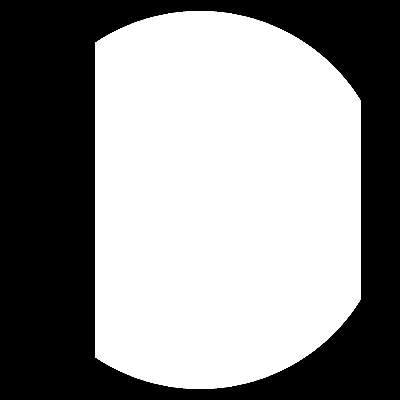

In [7]:
def get_base_mask(pad=40):
	base_mask = torch.ones(1, radius * 2, radius * 2, device=device)

	# set area outside image bounds to zero
	placeholder_img = torch.empty(img_shape, device=device)
	placeholder_img = placeholder_img[:,
		max(center[0] - radius, 0) : center[0] + radius,
		max(center[1] - radius, 0) : center[1] + radius
	]
	offset = (radius - center).maximum(torch.tensor([0], device=device))
	# u/d
	base_mask[:, :offset[0] + pad] = 0
	base_mask[:, max(offset[0] + placeholder_img.shape[1] - pad, 0):] = 0
	# l/r
	base_mask[:, :, :offset[1] + pad] = 0
	base_mask[:, :, max(offset[1] + placeholder_img.shape[2] - pad, 0):] = 0
	
	# get grid
	grid_x, grid_y = torch.meshgrid(
		*[torch.linspace(-1, 1, radius.item() * 2, device=device)
		for _ in range(2)], indexing='xy'
	)
	grid = torch.stack([grid_x, grid_y], dim=-1)
	
	# convert to polar
	grid_polar = torch.stack([
		grid.norm(dim=-1),
		torch.atan2(grid[..., 1], grid[..., 0])
	], dim=-1)

	# set area outside circle to zero
	base_mask[:, grid_polar[..., 0] > 1 - pad / radius] = 0
	return base_mask


base_mask = get_base_mask()
base_mask_400 = resize(base_mask, 400)
display.display(tensor_to_img(base_mask_400.expand(3, -1, -1)))

In [8]:
# get image distance at multiple scales
def mse_scales(images, masks=None, num_scales=6, scale_ratio=1.5):
	"""
	Get image distance using multiple scales
	Args:
		images: List of two image tensors of shape (b, c, h, w)
		masks: Corresponding masks, difference is multiplied by their intersection
		num_scales: Number of times images are scaled down
		scale_ratio: Images are scaled down by this factor
	Returns:
		Weighted average of MSEs s.t. expected value is the same at each scale
	"""
	# don't modify passed lists
	images = [*images]
	if masks is None:
		masks = [torch.ones_like(img[:, :1]) for img in images]
	else:
		masks = [*masks]
	
	losses = []
	weights = [1]
	for _ in range(num_scales - 1):
		mask_both = torch.mul(*masks)
		mask_mean = mask_both.mean()
		if mask_mean == 0:
			mask_mean = 1
		losses.append(torch.nn.functional.mse_loss(*[
			img * mask_both for img in images
		]) / mask_mean)
		for i in range(2):
			next_size = torch.tensor(images[i].shape[-2:]) // scale_ratio
			next_size = torch.maximum(next_size, torch.ones_like(next_size))
			next_size = next_size.int().tolist()
			images[i] = resize(images[i], next_size)
			masks[i] = resize(masks[i], next_size)
		
		# todo: correct math for this and weight scaling
		weights.append(weights[-1] * scale_ratio)
	
	weights = torch.tensor(weights[:-1], device=device)
	weights = weights / weights.sum() * num_scales**2
	losses = torch.stack(losses, dim=0)
	
	return (losses * weights).sum()

## Manual track

In [9]:
def stabilize_image(img, cam, mask=None):
	"""
	Translate img by cam coordinates (in range [-1, 1])
	Returns:
		Translated img and mask
	"""	
	if mask is None:
		mask = torch.ones_like(img[:1])
	
	# get grid
	grid_x, grid_y = torch.meshgrid(
		[torch.linspace(-1, 1, 400, device=device)
		for _ in range(2)], indexing='xy'
	)
	grid = torch.stack([grid_x, grid_y], dim=-1)
	
	# translate by cam
	grid += cam[None, None]
	img_warped = grid_sample(img[None], grid[None], mode='bicubic', align_corners=True)[0]
	mask_warped = grid_sample(mask[None], grid[None], mode='bicubic', align_corners=True)[0]
	
	return [img_warped.clip(0, 1), mask_warped.clip(0, 1)]

In [10]:
tqdm._instances.clear()

def show_stabilized(
	start_frame=0, end_frame=n_imgs - 1,
	fps=24, clip_path='output/pmv.mp4'
):
	first_img = process(file_to_tensor(f'{frames_path}/{start_frame}.jpg')).detach()
	# undistort images and translate by cam_track
	def make_frame(t):
		i = int(t / (1 / fps)) + start_frame
		i = min(max(i, start_frame), end_frame)

		img = process(file_to_tensor(f'{frames_path}/{i}.jpg'))
		img_warped, _ = stabilize_image(img, cam_track[i] - cam_track[start_frame])

		img = first_img * 0.5 + img_warped * 0.5
		return np.array(tensor_to_img(img))

	clip = mpy.VideoClip(make_frame, duration=(end_frame - start_frame + 1) / fps)
	clip.write_videofile(clip_path, fps=fps)
	display_video(clip_path, loop=True)

cam_track = torch.zeros(n_imgs, 2, device=device)
with torch.no_grad():
	cam_track[100:121] = torch.stack([
		torch.linspace(0, 0.15, 21, device=device),
		torch.zeros(21, device=device)
	], dim=-1)

show_stabilized(100, 120)

Moviepy - Building video output/pmv.mp4.
Moviepy - Writing video output/pmv.mp4



Moviepy - Done !
Moviepy - video ready output/pmv.mp4


## Automatic track

In [11]:
cam_deltas = torch.nn.Parameter(torch.zeros(n_imgs, 2, device=device))
opt = torch.optim.Adam(
	torch.nn.ParameterList([cam_deltas, distortion_alphas]),
	lr=0.00002
)

n_steps = 200000
max_frame_dist = 20

for train_step in tqdm(range(n_steps)):
	left_i = np.random.randint(n_imgs - 1)
	right_i = min(
		left_i + np.random.randint(max_frame_dist) + 1,
		n_imgs - 1
	)
	cam_delta = cam_deltas[left_i:right_i].sum(dim=0)

	left_img = file_to_tensor(f'{frames_path}/{left_i}.jpg')
	left_img = process(left_img)
	right_img = file_to_tensor(f'{frames_path}/{right_i}.jpg')
	right_img = process(right_img)

	right_img_warped, mask_warped = stabilize_image(right_img, cam_delta, base_mask_400)
	loss = mse_scales(
		[left_img[None], right_img_warped[None]],
		[base_mask_400[None], mask_warped[None]]
	)
	
	opt.zero_grad()
	loss.backward()
	opt.step()

	if (train_step + 1) % 10000 == 0:
		if cam_deltas.isnan().any() or distortion_alphas.isnan().any():
			print('nan')
		else:
			print('saving process vals')
			cam_track = torch.cat([
				torch.zeros_like(cam_deltas[:1]),
				cam_deltas.cumsum(dim=0)[:-1]
			], dim=0)
			
			vid_base_dir = video_path.rsplit('/', 1)[0]
			with open(f'{vid_base_dir}/process.pkl', 'wb') as f:
				pickle.dump({
					'img_shape': img_shape,
					'center': center.cpu(),
					'radius': radius.cpu(),
					'cam_track': cam_track.detach().cpu(),
					'distortion_alphas': distortion_alphas.detach().cpu()
				}, f)

  5%|▌         | 10002/200000 [16:50<5:27:40,  9.66it/s]

saving process vals


 10%|█         | 20001/200000 [33:38<5:11:39,  9.63it/s]

saving process vals


 15%|█▌        | 30001/200000 [50:30<4:58:44,  9.48it/s]

saving process vals


 20%|██        | 40001/200000 [1:07:20<4:35:17,  9.69it/s]

saving process vals


 25%|██▌       | 50002/200000 [1:24:12<4:23:03,  9.50it/s]

saving process vals


 30%|███       | 60000/200000 [1:41:03<4:23:34,  8.85it/s]

saving process vals


 35%|███▌      | 70001/200000 [1:57:56<4:03:23,  8.90it/s]

saving process vals


 40%|████      | 80002/200000 [2:14:49<3:27:04,  9.66it/s]

saving process vals


 45%|████▌     | 90000/200000 [2:31:40<3:10:49,  9.61it/s]

saving process vals


 50%|█████     | 100002/200000 [2:48:33<2:46:15, 10.02it/s]

saving process vals


 55%|█████▌    | 110001/200000 [3:05:28<2:45:40,  9.05it/s]

saving process vals


 60%|██████    | 120002/200000 [3:22:19<2:25:23,  9.17it/s]

saving process vals


 65%|██████▌   | 130002/200000 [3:39:11<2:03:34,  9.44it/s]

saving process vals


 70%|███████   | 140002/200000 [3:56:04<1:41:12,  9.88it/s]

saving process vals


 75%|███████▌  | 150001/200000 [4:12:57<1:28:30,  9.41it/s]

saving process vals


 80%|████████  | 160001/200000 [4:29:50<1:12:01,  9.25it/s]

saving process vals


 85%|████████▌ | 170002/200000 [4:46:43<51:21,  9.73it/s]  

saving process vals


 90%|█████████ | 180001/200000 [5:03:36<34:31,  9.65it/s]

saving process vals


 95%|█████████▌| 190002/200000 [5:20:28<17:48,  9.36it/s]

saving process vals


100%|██████████| 200000/200000 [5:37:19<00:00,  9.88it/s]

saving process vals


In [12]:
cam_track = torch.cat([
	torch.zeros_like(cam_deltas[:1]),
	cam_deltas.cumsum(dim=0)[:-1]
], dim=0)

show_stabilized(100, 120)

Moviepy - Building video output/pmv.mp4.
Moviepy - Writing video output/pmv.mp4



Moviepy - Done !
Moviepy - video ready output/pmv.mp4


In [13]:
print(cam_track[100:121])
print(distortion_alphas)

tensor([[ 0.0759, -0.0078],
        [ 0.0830, -0.0081],
        [ 0.0868, -0.0083],
        [ 0.0900, -0.0086],
        [ 0.0977, -0.0092],
        [ 0.1079, -0.0094],
        [ 0.1172, -0.0092],
        [ 0.1269, -0.0097],
        [ 0.1376, -0.0105],
        [ 0.1459, -0.0107],
        [ 0.1514, -0.0110],
        [ 0.1615, -0.0115],
        [ 0.1740, -0.0124],
        [ 0.1811, -0.0131],
        [ 0.1850, -0.0123],
        [ 0.1894, -0.0141],
        [ 0.1984, -0.0149],
        [ 0.2059, -0.0154],
        [ 0.2085, -0.0165],
        [ 0.2126, -0.0167],
        [ 0.2176, -0.0159]], device='cuda:0', grad_fn=<SliceBackward0>)
Parameter containing:
tensor([-0.0095, -0.0033,  0.0127], device='cuda:0', requires_grad=True)


In [14]:
tqdm._instances.clear()
# split full video into 20 stabilized segments
for i in range(20):
	print(f'{i + 1} / 20')
	show_stabilized(
		int((n_imgs - 1) / 20 * i),
		int((n_imgs - 1) / 20 * (i + 1)),
		fps=48,
		clip_path=f'output/pmv-{i}.mp4'
	)

1 / 20
Moviepy - Building video output/pmv-0.mp4.
Moviepy - Writing video output/pmv-0.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-0.mp4


2 / 20
Moviepy - Building video output/pmv-1.mp4.
Moviepy - Writing video output/pmv-1.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-1.mp4


3 / 20
Moviepy - Building video output/pmv-2.mp4.
Moviepy - Writing video output/pmv-2.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-2.mp4


4 / 20
Moviepy - Building video output/pmv-3.mp4.
Moviepy - Writing video output/pmv-3.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-3.mp4


5 / 20
Moviepy - Building video output/pmv-4.mp4.
Moviepy - Writing video output/pmv-4.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-4.mp4


6 / 20
Moviepy - Building video output/pmv-5.mp4.
Moviepy - Writing video output/pmv-5.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-5.mp4


7 / 20
Moviepy - Building video output/pmv-6.mp4.
Moviepy - Writing video output/pmv-6.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-6.mp4


8 / 20
Moviepy - Building video output/pmv-7.mp4.
Moviepy - Writing video output/pmv-7.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-7.mp4


9 / 20
Moviepy - Building video output/pmv-8.mp4.
Moviepy - Writing video output/pmv-8.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-8.mp4


10 / 20
Moviepy - Building video output/pmv-9.mp4.
Moviepy - Writing video output/pmv-9.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-9.mp4


11 / 20
Moviepy - Building video output/pmv-10.mp4.
Moviepy - Writing video output/pmv-10.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-10.mp4


12 / 20
Moviepy - Building video output/pmv-11.mp4.
Moviepy - Writing video output/pmv-11.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-11.mp4


13 / 20
Moviepy - Building video output/pmv-12.mp4.
Moviepy - Writing video output/pmv-12.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-12.mp4


14 / 20
Moviepy - Building video output/pmv-13.mp4.
Moviepy - Writing video output/pmv-13.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-13.mp4


15 / 20
Moviepy - Building video output/pmv-14.mp4.
Moviepy - Writing video output/pmv-14.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-14.mp4


16 / 20
Moviepy - Building video output/pmv-15.mp4.
Moviepy - Writing video output/pmv-15.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-15.mp4


17 / 20
Moviepy - Building video output/pmv-16.mp4.
Moviepy - Writing video output/pmv-16.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-16.mp4


18 / 20
Moviepy - Building video output/pmv-17.mp4.
Moviepy - Writing video output/pmv-17.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-17.mp4


19 / 20
Moviepy - Building video output/pmv-18.mp4.
Moviepy - Writing video output/pmv-18.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-18.mp4


20 / 20
Moviepy - Building video output/pmv-19.mp4.
Moviepy - Writing video output/pmv-19.mp4



Moviepy - Done !
Moviepy - video ready output/pmv-19.mp4
